# "Analisi" dei dati muonici

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
while not os.getcwd().endswith('Laboratorio_SiPM'):
    os.chdir('..')

import sys
sys.path.append('Config')
from lablib import *

## Spettro

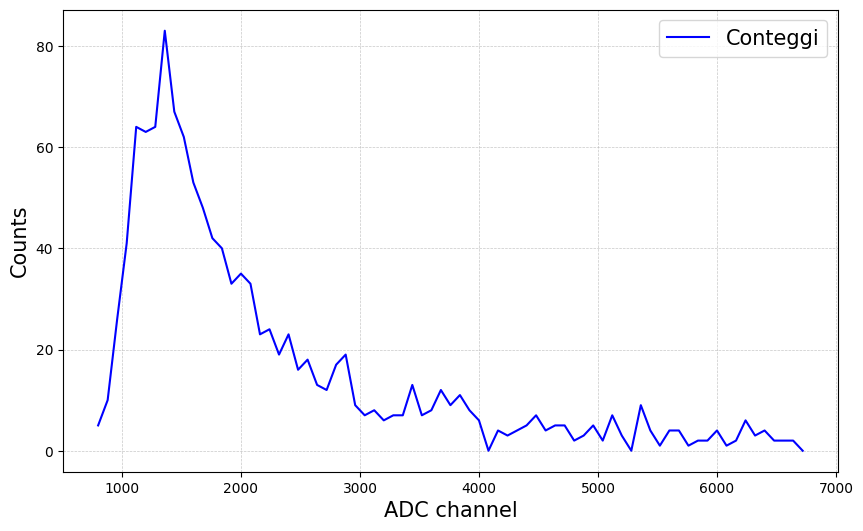

In [23]:
root_path = 'Dati/Parte 2/Muoni'
spettro = read_corretto(root_path + '/1ora.txt')

# Dimezza il numero di bin raggruppando ogni 2 righe
spettro_half_bins = spettro.groupby(spettro.index // 4).agg({'ADC': 'mean', 'Counts': 'sum'}).reset_index(drop=True)
spettro_ = crop_df(spettro_half_bins, 10, 1)

range = len(spettro_['ADC']) - 75

plt.figure(figsize=(10, 6))
plt.plot(spettro_['ADC'][:range], spettro_['Counts'][:range], label='Conteggi', color='blue')
plt.xlabel('ADC channel', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize = 15)
plt.show()

## Tentativo di fit con funzione di landau

In [19]:
errs = assign_errors(spettro_, lim=20, alt=0)

def landau_pdf(x, m, e, s):
    # Approximate Landau using a shift and scale from a fixed base function
    # A rough approximation using a shifted exponential for demonstration
    xi = (x - m) / e
    return s*np.exp(-0.5 * (xi + np.exp(-xi)))

par, val, err, *oth = LS_fit(spettro_['ADC'][:range], spettro_['Counts'][:range], errs[:range], landau_pdf, m=1500, e=10, s=80)
c2r = oth[2]/oth[1]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 70.96 (χ²/ndof = 1.0)      │              Nfcn = 340              │
│ EDM = 2.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │  1.391e3  │  0.019e3  │            │            │         │         │       │
│ 1 │ e    │    309    │    16     │            │            │         │         │       │
│ 2 │ s    │    105    │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────┐
│   │      m      e      s │
├───┼──────────────────────┤
│ m │    348 0.15e3    -43 │
│ e │ 0.15e3    242    -64 │
│ s │    -43    -64   28.7 │
└───┴──────────────────────┘

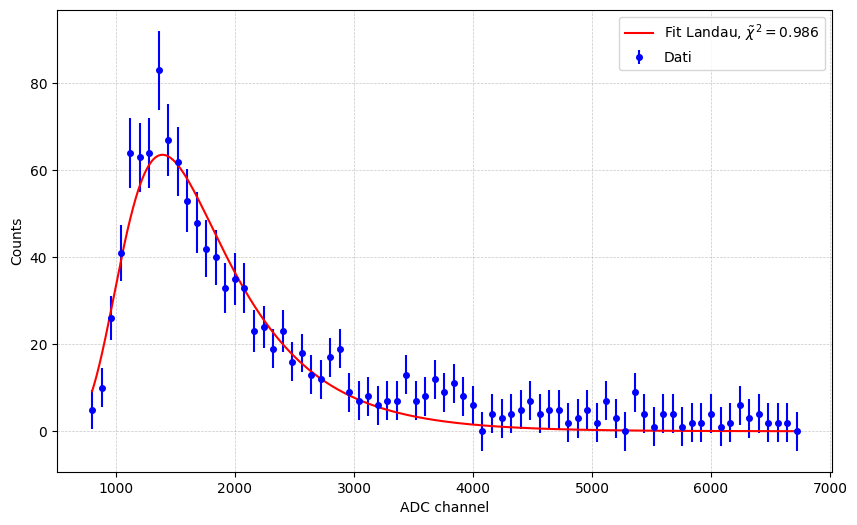

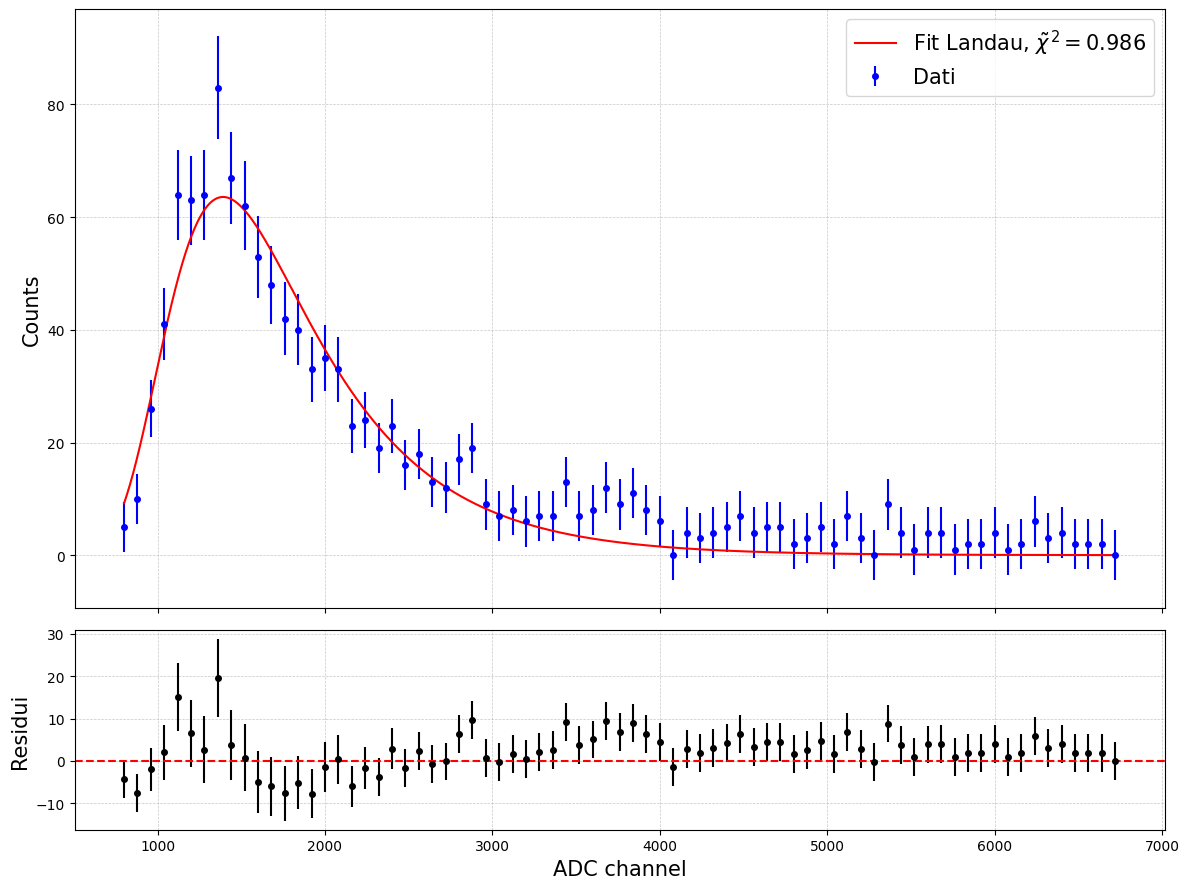

In [20]:
t = np.linspace(spettro_['ADC'].min(), spettro_['ADC'].max()-6000, 1000)

plt.figure(figsize=(10, 6))
plt.errorbar(spettro_['ADC'][:range], spettro_['Counts'][:range], yerr=errs[:range], fmt='o', label='Dati', color='blue', markersize=4)
plt.plot(t, landau_pdf(t, *val), label=fr'Fit Landau, $\tilde\chi^2 = {c2r:.3g}$', color='red')

plt.xlabel('ADC channel')
plt.ylabel('Counts')

plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()


# Calcolo dei residui
residui = spettro_['Counts'][:range] - landau_pdf(spettro_['ADC'][:range], *val)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Grafico principale
ax1.errorbar(spettro_['ADC'][:range], spettro_['Counts'][:range], yerr=errs[:range], fmt='o', label='Dati', color='blue', markersize=4)
ax1.plot(t, landau_pdf(t, *val), label=fr'Fit Landau, $\tilde\chi^2 = {c2r:.3g}$', color='red')
ax1.set_ylabel('Counts' , fontsize=15)
ax1.grid(linestyle='--', linewidth=0.5, alpha=0.7)
ax1.legend(fontsize=15)

# Grafico dei residui
ax2.errorbar(spettro_['ADC'][:range], residui, yerr=errs[:range], fmt='o', color='black', markersize=4)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel('ADC channel', fontsize=15)
ax2.set_ylabel('Residui', fontsize=15)
ax2.grid(linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

## Staircase

In [21]:
staircase = pd.read_csv(root_path + '/staircase.txt', sep='	').dropna()

staircase.loc[4, 'Frequency_d'] = (staircase['Frequency_d'][3] - staircase['Frequency_d'][5]) / 2.5

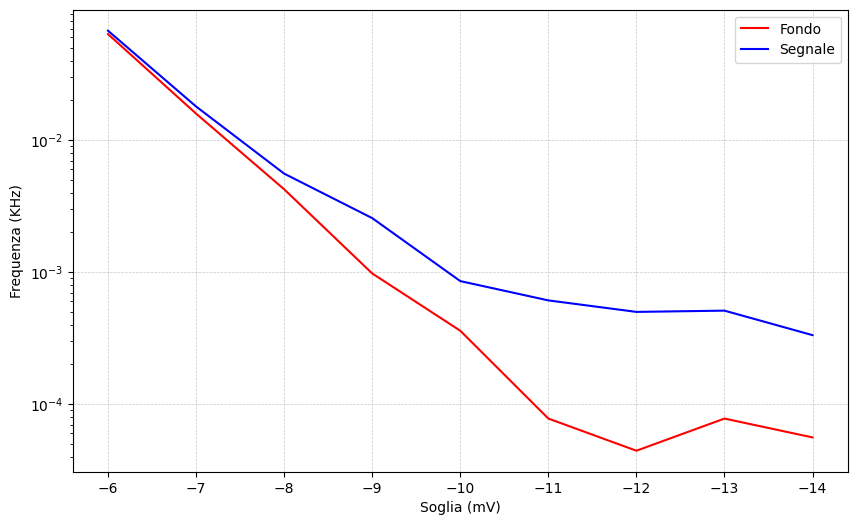

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(staircase['Threshold_d'], staircase['Frequency_d'], label='Fondo', color='red')
plt.plot(staircase['Threshold_s'], staircase['Frequency_s'], label='Segnale', color='blue')
plt.gca().invert_xaxis()

plt.yscale('log')
plt.xlabel('Soglia (mV)')
plt.ylabel('Frequenza (KHz)')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)

plt.xticks(np.arange(int(staircase['Threshold_d'].min()), int(staircase['Threshold_d'].max()) + 1, 1))
plt.show()